In [1]:
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import pyswarms as ps
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score,average_precision_score,recall_score,roc_auc_score
from sklearn.preprocessing import RobustScaler,StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score,KFold,StratifiedKFold, GridSearchCV


In [33]:
import math
from sklearn import tree
from statistics import mean
from sklearn import metrics
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
raw_data = pd.read_csv('PhishingData.csv')

In [5]:
lb_enc = LabelEncoder()
raw_data["NEW_RESULT"] = lb_enc.fit_transform(raw_data["Result"])
raw_data[["Result", "NEW_RESULT"]]
df = raw_data.drop(['Result'], axis = 1)
df.head(10)
coloum = df.shape[1] - 1

In [6]:
data_X = df.drop(['NEW_RESULT'], axis=1)
data_y = pd.DataFrame(df['NEW_RESULT'])
y = data_y.loc[:,:].values
X = data_X.iloc[:,:].values

In [7]:
np.set_printoptions(threshold=sys.maxsize)
#print(y)

In [8]:
y = np.where(y >= 1, 1, 0)
#print(y)

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
  
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [10]:
from sklearn import linear_model

# Create an instance of the classifier
classifier = linear_model.LogisticRegression()

# Define objective function
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    total_features = coloum
    # Get the subset of the features from the binary mask
    if np.count_nonzero(m) == 0:
        X_subset = X
    else:
        X_subset = X[:,m==1]
    # Perform classification and store performance in P
    classifier.fit(X_subset, y)
    P = (classifier.predict(X_subset) == y).mean()
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    return j

In [11]:
def f(x, alpha=0.88):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

In [12]:
%%time
# Initialize swarm, arbitrary
options = {'c1': 0.6, 'c2': 0.4, 'w':0.8, 'k': 30, 'p':2}

# Call instance of PSO
dimensions = coloum # dimensions should be the number of features
optimizer = ps.discrete.BinaryPSO(n_particles=50, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=200)


2021-10-16 11:32:56,424 - pyswarms.discrete.binary - INFO - Optimize for 200 iters with {'c1': 0.6, 'c2': 0.4, 'w': 0.8, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|███████████████████████████████████████████████████████████████|200/200, best_cost=0.439
2021-10-16 11:40:08,234 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.4393257981360301, best pos: [1 1 1 1 1 1 1 1 1]


Wall time: 7min 11s


In [14]:
# Create two instances of LogisticRegression
classfier = linear_model.LogisticRegression()

# Get the selected features from the final positions
X_selected_features = X[:,pos==1]  # subset

# Perform classification and store performance in P
classifier.fit(X_selected_features, y)

# Compute performance
subset_performance = (classifier.predict(X_selected_features) == y).mean()


print('Subset performance: %.3f' % (subset_performance))

Subset performance: 0.501


# Train Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_selected_features, y, test_size=0.25, random_state=0, stratify=y)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(1014, 9)
(339, 9)
(1014, 1)
(339, 1)


# Evalution Function

In [16]:
def evaluation(clf, X, Y):
    print(f'Accuracy')
    acc = cross_val_score(clf, X, Y, scoring="accuracy", cv = 5)
    print(acc)
    print("Accuracy Score (Mean): ", acc.mean())
    print("Standard Error: ", acc.std())
    

    print(f'\nF1 Score')
    f1_score = cross_val_score(clf, X, Y, scoring="f1", cv = 5)
    print(f1_score)
    print("F1 Score (Mean): ", f1_score.mean())
    print("Standard Error: ", f1_score.std())
    
    print(f'\nPrecision')
    pre = cross_val_score(clf, X, Y, scoring="precision", cv = 5)
    print(pre)
    print("Precision (Mean): ", pre.mean())
    print("Standard Error: ", pre.std())
    
    print(f'\nSensitivity')
    rec = cross_val_score(clf, X, Y, scoring="recall", cv = 5)
    print(rec)
    print("Recall (Mean): ", rec.mean())
    print("Standard Error: ", rec.std())

# Decision tree

In [17]:
def hyperParameterTuning_DecisionTree(features, labels):
    params = {
        "max_features": ["auto", "sqrt", "log2"],
        "min_samples_leaf": [3, 4, 5],
        "min_samples_split": [8, 10, 12],
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 20, 30, 40, 50],
        "random_state": [10, 20, 30, 40, 50]
    }
    
    rf_model = DecisionTreeClassifier()
    
    gsearch = GridSearchCV(estimator = rf_model, param_grid = params, cv = 5, n_jobs = -1, verbose = 1)
    
    gsearch.fit(features,labels)
    
    return gsearch.best_params_

In [17]:
hyperParameterTuning_DecisionTree(X_train, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'random_state': 10}

In [18]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features='auto',
                                      min_samples_leaf = 4, min_samples_split = 8, random_state = 10)

In [19]:
evaluation(clf_tree, X_test, y_test)

Accuracy
[0.85294118 0.85294118 0.85294118 0.86764706 0.8358209 ]
Accuracy Score (Mean):  0.8524582967515364
Standard Error:  0.010081677751331834

F1 Score
[0.83870968 0.85714286 0.84375    0.85714286 0.83076923]
F1 Score (Mean):  0.84550292449486
Standard Error:  0.010366086484435714

Precision
[0.86666667 0.81081081 0.87096774 0.9        0.81818182]
Precision (Mean):  0.8533254075189559
Standard Error:  0.03379444199076564

Sensitivity
[0.8125     0.90909091 0.81818182 0.81818182 0.84375   ]
Recall (Mean):  0.8403409090909092
Standard Error:  0.03604261710716749


# K-Nearest Neighbors

In [20]:
def hyperParameterTuning_KNN(features, labels):
    params = {
        "n_neighbors": [3, 5, 8, 10, 13],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree"],
        "metric": ["minkowski", "euclidean", "manhattan"],
        "p": [1, 2, 3, 4, 5]
    }
    
    rf_model = KNeighborsClassifier()
    
    gsearch = GridSearchCV(estimator = rf_model, param_grid = params, cv = 5, n_jobs = -1, verbose = 1)
    
    gsearch.fit(features,labels)
    
    return gsearch.best_params_

In [21]:
hyperParameterTuning_KNN(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


{'algorithm': 'ball_tree',
 'metric': 'minkowski',
 'n_neighbors': 13,
 'p': 1,
 'weights': 'uniform'}

In [21]:
clf_KNN = KNeighborsClassifier(algorithm = "ball_tree", metric = "minkowski", n_neighbors = 13, p = 1, weights = "uniform")

In [22]:
evaluation(clf_KNN, X_test, y_test)

Accuracy
[0.92647059 0.83823529 0.80882353 0.82352941 0.7761194 ]
Accuracy Score (Mean):  0.8346356453028971
Standard Error:  0.05031973485654781

F1 Score
[0.92307692 0.84057971 0.8115942  0.8        0.7761194 ]
F1 Score (Mean):  0.8302740478210952
Standard Error:  0.050826686822576565

Precision
[0.90909091 0.80555556 0.77777778 0.88888889 0.74285714]
Precision (Mean):  0.8248340548340547
Standard Error:  0.06404437070836386

Sensitivity
[0.9375     0.87878788 0.84848485 0.72727273 0.8125    ]
Recall (Mean):  0.840909090909091
Standard Error:  0.07006039962746141


# Random Forest  

In [23]:
def hyperParameterTuning_RF(features, labels):
    params = {
        "n_estimators": [30, 50, 70, 100],
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 20, 30, 40, 50],
        "random_state": [10, 20, 30, 40, 50]
    }
    
    rf_model = RandomForestClassifier()
    
    gsearch = GridSearchCV(estimator = rf_model, param_grid = params, cv = 5, n_jobs = -1, verbose = 1)
    
    gsearch.fit(features,labels)
    
    return gsearch.best_params_

In [25]:
hyperParameterTuning_RF(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 70, 'random_state': 20}

In [24]:
clf_rf = RandomForestClassifier(criterion = 'gini', max_depth = 10, n_estimators = 70, random_state = 20)

In [25]:
evaluation(clf_rf, X_test, y_test)

Accuracy
[0.86764706 0.83823529 0.88235294 0.83823529 0.80597015]
Accuracy Score (Mean):  0.8464881474978052
Standard Error:  0.02650249163244333

F1 Score
[0.85245902 0.84057971 0.87878788 0.81355932 0.8       ]
F1 Score (Mean):  0.8370771854720294
Standard Error:  0.027987346861358228

Precision
[0.89655172 0.80555556 0.87878788 0.92307692 0.78787879]
Precision (Mean):  0.8583701738874152
Standard Error:  0.052573940796874406

Sensitivity
[0.8125     0.87878788 0.87878788 0.72727273 0.8125    ]
Recall (Mean):  0.821969696969697
Standard Error:  0.05586318637785084


# Support Vector Machine

In [26]:
def hyperParameterTuning_SVC(features, labels):
    params = {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "C": [1, 3, 5],
        "random_state": [10, 20, 30, 40, 50]
    }
    
    rf_model = SVC()
    
    gsearch = GridSearchCV(estimator = rf_model, param_grid = params, cv = 5, n_jobs = -1, verbose = 1)
    
    gsearch.fit(features,labels)
    
    return gsearch.best_params_

In [29]:
hyperParameterTuning_SVC(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'C': 5, 'kernel': 'rbf', 'random_state': 10}

In [27]:
clf_svm = SVC(random_state = 10, kernel='rbf', C = 5)

In [28]:
evaluation(clf_svm, X_test, y_test)

Accuracy
[0.91176471 0.83823529 0.88235294 0.83823529 0.86567164]
Accuracy Score (Mean):  0.8672519754170326
Standard Error:  0.02791363602963835

F1 Score
[0.90625    0.84057971 0.875      0.82539683 0.86153846]
F1 Score (Mean):  0.8617529994160428
Standard Error:  0.028019963168480114

Precision
[0.90625    0.80555556 0.90322581 0.86666667 0.84848485]
Precision (Mean):  0.8660365754317366
Standard Error:  0.03732712771806209

Sensitivity
[0.90625    0.87878788 0.84848485 0.78787879 0.875     ]
Recall (Mean):  0.8592803030303031
Standard Error:  0.040121129153992775


# Artificial Neural Network

In [29]:
def hyperParameterTuning_MLP(features, labels):
    params = {
        "hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)],
        "activation": ['tanh', 'relu'],
        "max_iter": [500, 600, 800, 1000],
        "learning_rate": ['constant','adaptive', "invscaling"],
        "random_state": [10, 20, 30, 40, 50]
    }
    
    rf_model = MLPClassifier()
    
    gsearch = GridSearchCV(estimator = rf_model, param_grid = params, cv = 5, n_jobs = -1, verbose = 1)
    
    gsearch.fit(features,labels)
    
    return gsearch.best_params_

In [33]:
hyperParameterTuning_MLP(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'activation': 'relu',
 'hidden_layer_sizes': (50, 100, 50),
 'learning_rate': 'constant',
 'max_iter': 500,
 'random_state': 10}

In [30]:
clf_mlp = MLPClassifier(activation = "relu", hidden_layer_sizes = (50, 100, 50), learning_rate = "constant", 
                        max_iter = 500, random_state = 10) 

In [31]:
evaluation(clf_mlp, X_test, y_test)

Accuracy
[0.92647059 0.82352941 0.85294118 0.80882353 0.86567164]
Accuracy Score (Mean):  0.8554872695346797
Standard Error:  0.040859869988547584

F1 Score
[0.92307692 0.82352941 0.84848485 0.78688525 0.86153846]
F1 Score (Mean):  0.8487029781533156
Standard Error:  0.045058675886546135

Precision
[0.90909091 0.8        0.84848485 0.85714286 0.84848485]
Precision (Mean):  0.8526406926406926
Standard Error:  0.03467702705096857

Sensitivity
[0.9375     0.84848485 0.84848485 0.72727273 0.875     ]
Recall (Mean):  0.8473484848484849
Standard Error:  0.06828275357117423


# ROC Curve

In [35]:
def roc_curve_normal(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)
    
    clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features='auto',
                                      min_samples_leaf = 4, min_samples_split = 8, random_state = 10)
    clf_tree.fit(X_train, y_train)
    #Curve Point
    #y_score1 = clf_random.predict_proba(X_test)[:,1]
    #false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    #print(false_positive_rate1, true_positive_rate1, threshold1)
    
    #X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)
    clf_KNN = KNeighborsClassifier(algorithm = "ball_tree", metric = "minkowski", n_neighbors = 13, p = 1, weights = "uniform")
    clf_KNN.fit(X_train, y_train)
    
    clf_rf = RandomForestClassifier(criterion = 'gini', max_depth = 10, n_estimators = 70, random_state = 20)
    clf_rf.fit(X_train, y_train)
    
    clf_svm = SVC(random_state = 10, kernel='rbf', C = 5)
    clf_svm.fit(X_train, y_train)
    
    clf_mlp = MLPClassifier(activation = "relu", hidden_layer_sizes = (50, 100, 50), learning_rate = "constant", 
                        max_iter = 500, random_state = 10) 
    clf_mlp.fit(X_train, y_train)
    
    
    ax = plt.gca()
    
    clf_tree_disp = plot_roc_curve(clf_tree, X_test, y_test, ax=ax, alpha=0.8)
    clf_KNN_disp  = plot_roc_curve(clf_KNN, X_test, y_test, ax=ax, alpha=0.8)
    clf_rf_disp   = plot_roc_curve(clf_rf, X_test, y_test, ax=ax, alpha=0.8)
    clf_svm_disp  = plot_roc_curve(clf_svm, X_test, y_test, ax=ax, alpha=0.8)
    clf_mlp_disp  = plot_roc_curve(clf_mlp, X_test, y_test, ax=ax, alpha=0.8)
    
    ax.figure.set_size_inches(20, 12)
    plt.show()

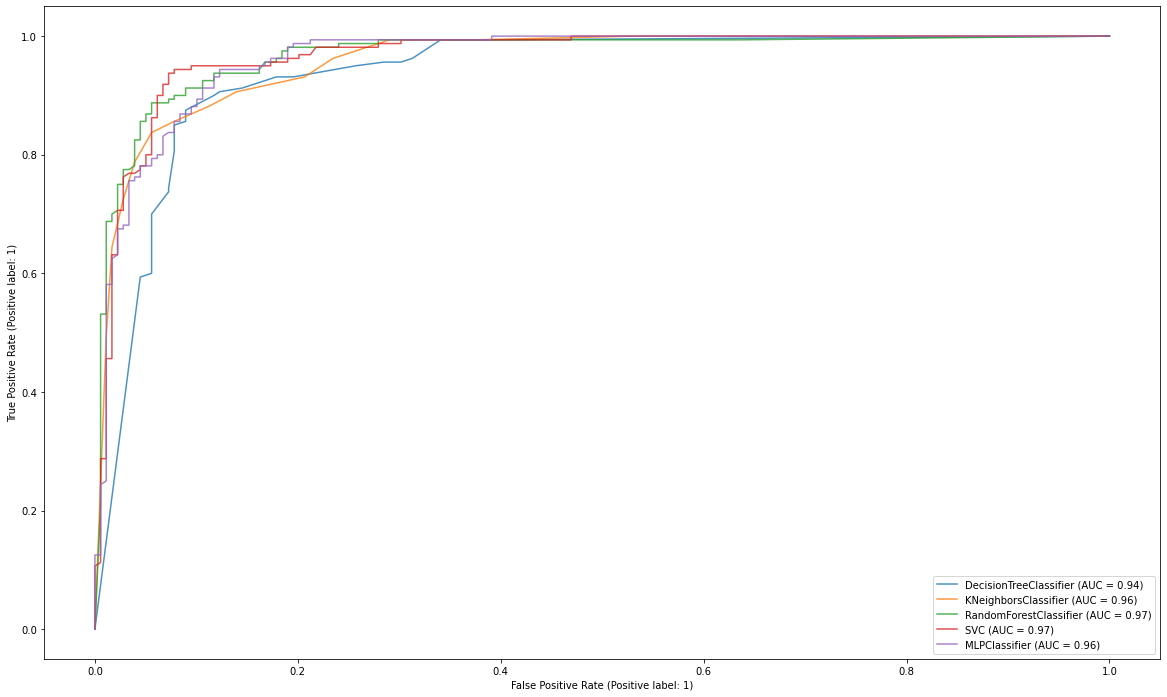

In [36]:
roc_curve_normal(X_selected_features, y) 